# Classification de sons urbains avec Machin Learning et Deep Learning

**Dataset : UrbanSound8K**
Attention c'est très probable que la lecture dynamique ne fonctionne qu'avec WSL.
Travaillez dans un environnement Ubuntu pour ce projet. 


In [624]:
# import
import os
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from numpy.fft import fft, fftshift  

import librosa 
import librosa.display 
from IPython.display import Audio, display


import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [625]:
# parametr de visualisation (plt)
plt.rcParams.update({
    # --- Фон ---
    "figure.facecolor": "#121212",
    "axes.facecolor": "#121212",
    "savefig.facecolor": "#121212",

    # --- Текст и оси ---
    "text.color": "white",
    "axes.labelcolor": "white",
    "axes.edgecolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",

    # --- Сетка ---
    "axes.grid": True,
    "grid.color": "#535252",
    "grid.alpha": 0.5,

    # --- Легенда ---
    "legend.facecolor": "#121212",
    "legend.edgecolor": "white",

    # --- Цвета линий (cycle) ---
    "axes.prop_cycle": plt.cycler(color=[
        "#6218B6",  # blue
        "#2532EE",  # orange
        "#1CE6C4",  # green
        "#0CD63F",  # red
        "#F1EE2A",  # purple
        "#F37C15",  # brown
        "#EE1924",  # cyan
    ]),

    # --- Толщина ---
    "lines.linewidth": 1.0,
})

In [626]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset: UrbanSound8K
---

##### Description du Dataset

C'est ici qu'il faut être précis, car la structure est particulière :

* **Nombre d'échantillons :** 8 732 extraits sonores.
* **Durée :** Chaque extrait dure au maximum **4 secondes**.
* **Format :** Fichiers `.wav` (mono ou stéréo selon l'extrait).
* **Les 10 Classes :**
1. `air_conditioner`
2. `car_horn`
3. `children_playing`
4. `dog_bark`
5. `drilling`
6. `engine_idling`
7. `gun_shot`
8. `jackhammer`
9. `siren`
10. `street_music`

##### Structure des fichiers (Le système de "Folds")

Le dataset est organisé en **10 dossiers nommés `fold1` à `fold10`**.

* **Pourquoi ?** Pour la **validation croisée (Cross-Validation)**. On ne mélange pas les fichiers au hasard. Pour un test honnête, on s'entraîne sur les folds 1 à 9 et on teste sur le fold 10.
* **Le fichier CSV (`UrbanSound8K.csv`) :** Il contient les colonnes essentielles :
* `slice_file_name` : Nom du fichier.
* `fold` : Le numéro du dossier.
* `classID` : L'index de la classe (0 à 9).
* `class` : Le nom de la catégorie.
  
---
## 1. Chargement et Découverte (EDA)

Le dataset [Kaggle - UrbanSound8K](https://www.kaggle.com/datasets/chrisfilo/urbansound8k) est complexe. Il est divisé en 10 "folds" pour permettre une validation croisée rigoureuse.



* **Tâche 1.1 :** Chargez le fichier `UrbanSound8K.csv`. Affichez le nombre d'échantillons par classe.
* **Tâche 1.2 :** Écoutez un échantillon de chaque catégorie. Que remarquez-vous sur la durée des sons ? Sont-ils tous identiques ?
* **Tâche 1.3 :** Visualisez la forme d'onde (waveform) d'un "dog_bark" et d'un "drilling".

In [627]:
# Telecharger le dataset
path_data = r"C:\Users\Utilisateur\Simplon\Audio_dataset\archive (9)"

df = pd.read_csv(r"C:\Users\Utilisateur\Simplon\Audio_dataset\archive (9)\UrbanSound8K.csv")

# Ajouter le path global pour chaque fiche
df['fold'] = df['fold'].astype(str)
df['path_file'] = df.apply(
    lambda row: os.path.join(
        path_data,
        "fold" + row['fold'],
        row['slice_file_name']
    ),
    axis=1
)
df.head()

slice_file_name    fsID  start        end  salience fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1    5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1    5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1    5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1    5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1    5        2   

              class                                          path_file  
0          dog_bark  C:\Users\Utilisateur\Simplon\Audio_dataset\arc...  
1  children_playing  C:\Users\Utilisateur\Simplon\Audio_dataset\arc...  
2  children_playing  C:\Users\Utilisateur\Simplon\Audio_dataset\arc...  
3  children_playing  C:\Users\Utilisateur\Simplon\Audio_dataset\arc...  
4  children_playing  C:\Users\Utilisateur\Simplon\Audio_dataset\arc...

In [628]:
# le nombre d'échantillons par classe
df.groupby(by="class").size()

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
dtype: int64

In [629]:
# Sampling pour class dirrerents et memes types
def sampling(N_ex, mode='random'):
    samples = []
    idx_list = []

    if mode == 'random':
        # Выбираем N_ex разных классов
        classes = np.random.choice(df['class'].unique(), N_ex, replace=False)
        
        for cls in classes:
            # Случайный файл для каждого выбранного класса
            idx = df[df['class'] == cls].sample(1).index[0]
            idx_list.append(idx)

    elif mode == 'same':
        # Выбираем один случайный класс
        target_class = np.random.choice(df['class'].unique())
        
        # Случайные N_ex файлов этого класса
        idx_list = df[df['class'] == target_class].sample(N_ex).index.tolist()

    for i in range(N_ex):
           
        idx = idx_list[i]
        fold = df.loc[idx, 'fold']
        file_name = df.loc[idx, 'slice_file_name']
        
        path_ex = os.path.join(
            r"C:\Users\Utilisateur\Simplon\Audio_dataset\archive (9)",
            f"fold{fold}",
            file_name
        )

        y_i, fs_i = librosa.load(path_ex, sr=None)
        
        samples.append({
            "signal": y_i,
            "sr": fs_i,
            "class": df.loc[idx, 'class']
        })
    return samples




In [630]:
N_ex = 10
samples = sampling(N_ex)

In [631]:
# Écouter un échantillon de chaque catégorie

for i, s in enumerate(samples):
    print(f"Sample {i} — Class: {s['class']}")
    display(Audio(data=s['signal'], rate=s['sr']))

Sample 0 — Class: street_music


Sample 1 — Class: drilling


Sample 2 — Class: engine_idling


Sample 3 — Class: car_horn


Sample 4 — Class: dog_bark


Sample 5 — Class: children_playing


Sample 6 — Class: jackhammer


Sample 7 — Class: air_conditioner


Sample 8 — Class: siren


Sample 9 — Class: gun_shot


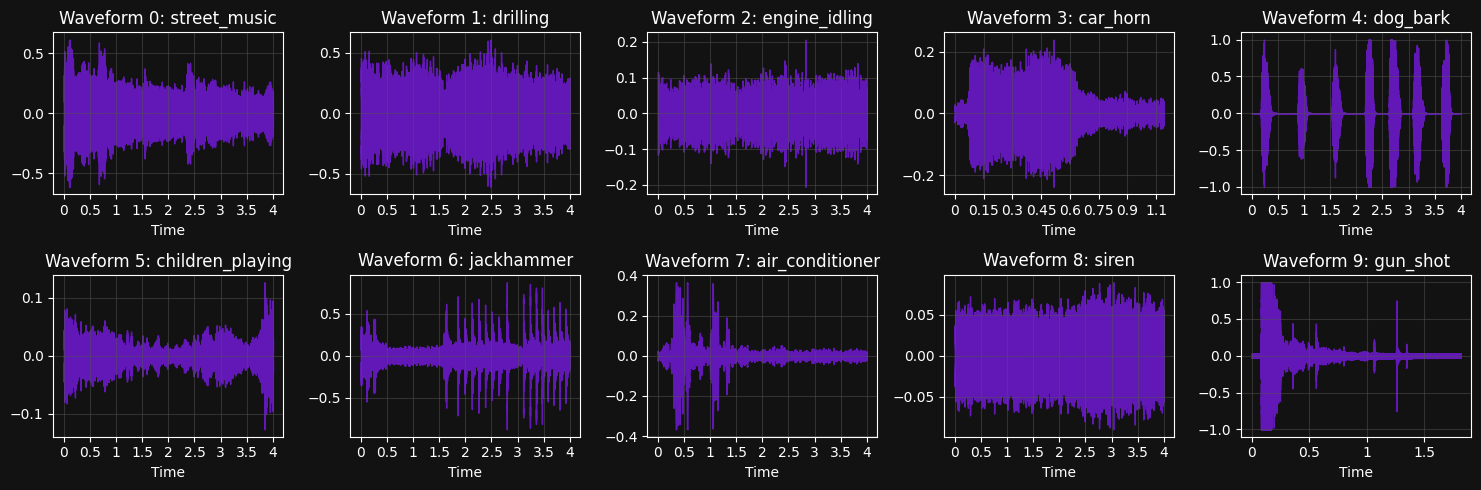

In [632]:
# Visualiser la forme d'onde (waveform)

def show_waveform(samples, N_ex):
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))

    for i in range(N_ex):
        librosa.display.waveshow(y=samples[i]["signal"], sr=samples[i]["sr"], ax=axes[i//5, i%5])
        ax=axes[i//5, i%5].set_title(f'Waveform {i}: {samples[i]["class"]}')

    plt.tight_layout()
    plt.show()

show_waveform(samples, N_ex)

## 2. Exploration des Transformations

Avant de lancer l'IA, nous devons transformer l'audio (1D) en représentation temps-fréquence (2D).

* **STFT (Short-Time Fourier Transform) :** Affichez le spectrogramme linéaire d'un son.
* **Mel-Spectrogramme :** Pourquoi cette échelle est-elle plus pertinente pour l'oreille humaine ? Affichez la différence.
* **MFCC :** Calculez les coefficients MFCC. Comparez visuellement deux sons de la **même catégorie** puis deux sons **différents**. Les motifs sont-ils reconnaissables ?
* Recalculez les MFCC moyens en comprenant et en utilisant `librosa.effects.split`

In [633]:
def show_spectrogramme_linaire(samples, N_ex):
    n_fft=2048
    hop_length=512

    fig, axes = plt.subplots(2, N_ex//2, figsize=(20, 6))


    for  i in range(N_ex):
        # 1. STFT (module)
        y = samples[i]["signal"]
        sr = samples[i]["sr"]


        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
        S = np.abs(D)

        # 2. Conversion en dB (échelle logarithmique)
        S_db = librosa.amplitude_to_db(S, ref=np.max)

        # visualisation
        librosa.display.specshow(
            S_db,
            sr=sr,
            hop_length=hop_length,
            x_axis='time',
            y_axis='linear',
            ax=axes[i//5, i%5]  # échelle fréquentielle linéaire
        )
        axes[i//5, i%5].set_title(f'spectrogramme_linaire: {samples[i]["class"]}')



def show_spectrogramme_mel(samples, N_ex):

    n_fft=2048
    hop_length=512
    n_mels=128

    fig, axes = plt.subplots(2, N_ex//2, figsize=(20, 6))

    for i in range(N_ex):
        y = samples[i]["signal"]
        sr = samples[i]["sr"]

        # Spectrogramme de puissance
        S = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            power=2.0   # spectrogramme de puissance
        )
        # 2. Conversion en dB
        S_db = librosa.power_to_db(S, ref=np.max)

        # visualisation
        librosa.display.specshow(
            S_db,
            sr=sr,
            hop_length=hop_length,
            x_axis='time',
            y_axis='linear',
            ax=axes[i//5, i%5]   # échelle fréquentielle linéaire
        )
        axes[i//5, i%5].set_title(f'spectrogramme_mel: {samples[i]["class"]}')




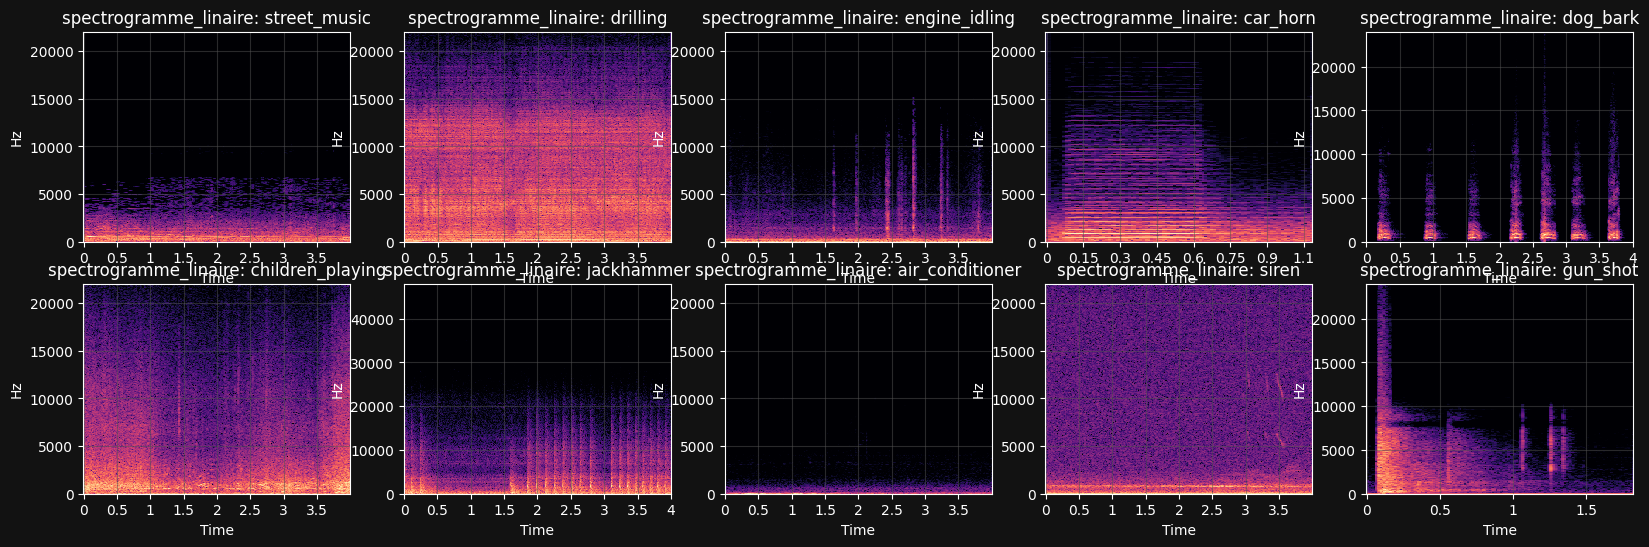

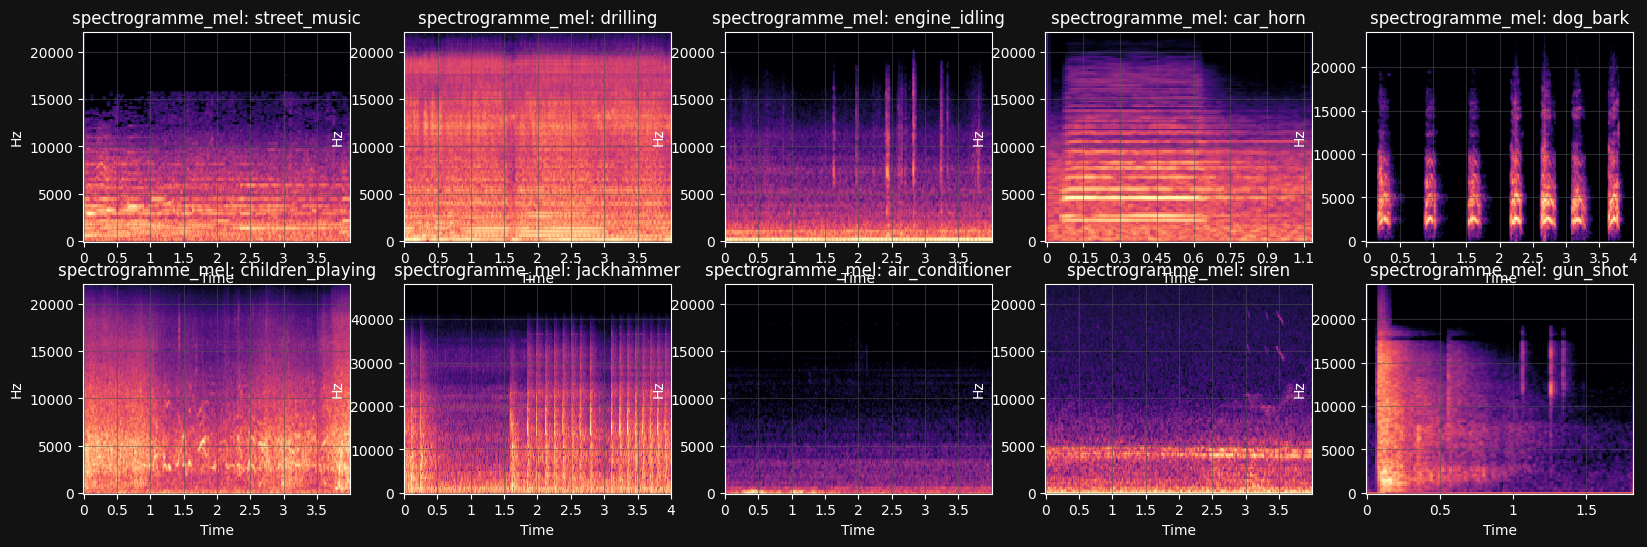

In [634]:
show_spectrogramme_linaire(samples, N_ex)
show_spectrogramme_mel(samples, N_ex)

In [635]:
def y_trim(y):
    intervals = librosa.effects.split(y)
    y_trimmed = np.concatenate([y[start:end] for start, end in intervals])
    return y_trimmed


In [636]:
def compute_mfcc_embeddings(samples, n_mfcc=20, n_fft=2048, hop_length=512):
    """
    Вычисляет MFCC embeddings для каждого аудиосигнала.
    Возвращает массив shape (N_samples, n_mfcc)
    """
    embeddings = []
    embeddings_trim = []
    
    for s in samples:
        y = s["signal"]
        sr = s["sr"]
        y_trimmered = y_trim(y)
        # MFCC (20 x T)

        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=n_mfcc,
            n_fft=n_fft,
            hop_length=hop_length
        )
        
        mfcc_trim = librosa.feature.mfcc(
            y=y_trimmered,
            sr=sr,
            n_mfcc=n_mfcc,
            n_fft=n_fft,
            hop_length=hop_length
        )

        mfcc_mean = np.mean(mfcc, axis=1)
        embeddings.append(mfcc_mean)

        mfcc_mean_trim = np.mean(mfcc_trim, axis=1)
        embeddings_trim.append(mfcc_mean_trim)
    
    embeddings = np.array(embeddings)
    embeddings_trim = np.array(embeddings_trim)
    
    return embeddings, embeddings_trim

In [637]:
samples_same = sampling(10, mode="same")
embeddings_same = compute_mfcc_embeddings(samples_same)[0]

embeddings = compute_mfcc_embeddings(samples)[0]

Text(0.5, 1.0, 'Samples same type')

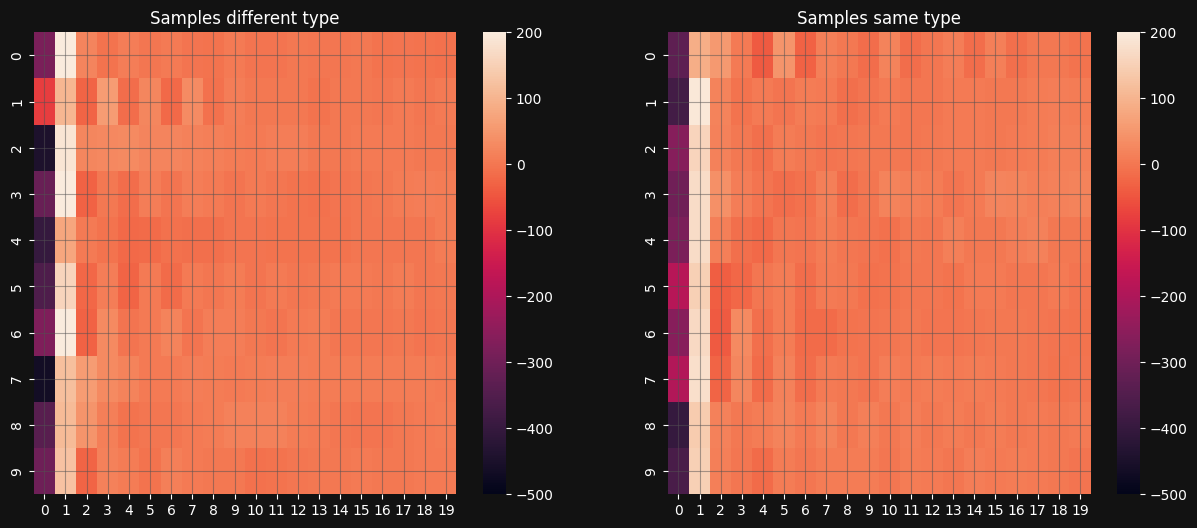

In [638]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(embeddings, ax=axes[0], vmin=-500, vmax=200)
sns.heatmap(embeddings_same, ax=axes[1], vmin=-500, vmax=200)

axes[0].set_title("Samples different type")
axes[1].set_title("Samples same type")

Text(0.5, 1.0, 'Signat with trimmering')

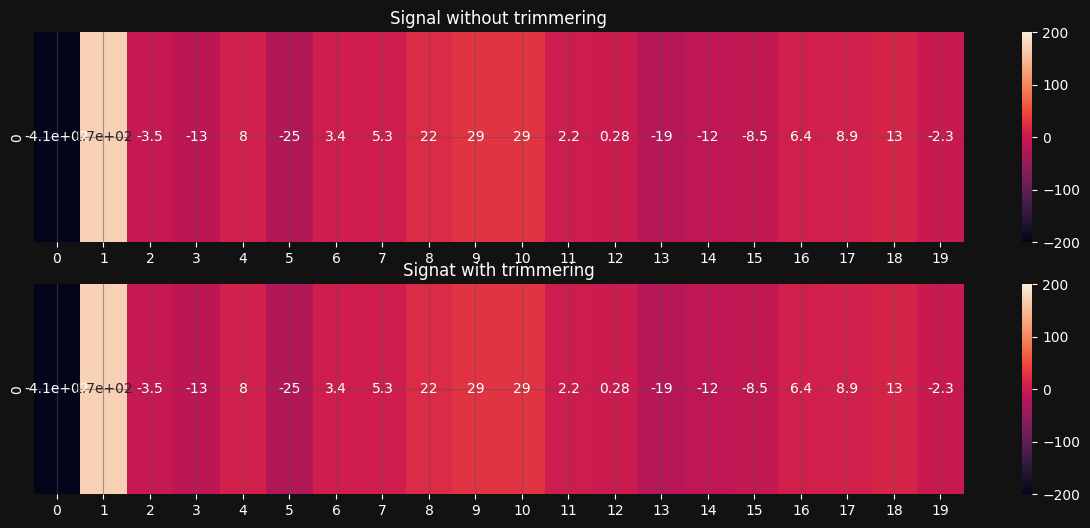

In [639]:
samples = sampling(1)

embeddings = compute_mfcc_embeddings(samples)[0]
embeddings_trim = compute_mfcc_embeddings(samples)[1]

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

sns.heatmap(embeddings, ax=axes[0], vmin=-200, vmax=200, annot=True)
sns.heatmap(embeddings_trim, ax=axes[1], vmin=-200, vmax=200, annot=True)


axes[0].set_title("Signal without trimmering")
axes[1].set_title("Signat with trimmering")

# ML
---
Dans cette partie du notebook, nous réalisons une comparaison de trois modèles de Machine Learning — Logistic Regression (LR), Support Vector Classifier (SVC) et Random Forest Classifier (RFC) — appliqués à la classification de signaux audio.

Les modèles sont entraînés sur les mêmes features (MFCC et descripteurs spectraux) et évalués à l’aide des métriques suivantes : accuracy, precision, recall, F1-score ainsi que la matrice de confusion.

L’objectif est d’analyser les performances respectives de chaque approche afin d’identifier le modèle le plus robuste et le plus adapté à la séparation des différentes classes sonores.

In [640]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    
    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    
    # features suplimaintaires
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    rms = np.mean(librosa.feature.rms(y=y))
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    
    return np.concatenate([mfcc_mean, mfcc_std, chroma, [zcr, rms, centroid]])

In [641]:
X = []
y = []

for i in range(len(df)):

    file_path = df.loc[i, "path_file"]
    features = extract_features(file_path)
    X.append(features)
    y.append(df.loc[i, "class"])

X = np.array(X)
y = np.array(y)

c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [642]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y, y_encoded

(array(['dog_bark', 'children_playing', 'children_playing', ...,
        'car_horn', 'car_horn', 'car_horn'], shape=(8732,), dtype='<U16'),
 array([3, 2, 2, ..., 1, 1, 1], shape=(8732,)))

In [643]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6985, 41), (1747, 41), (6985,), (1747,))

In [644]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Model: LogisticRegression

In [645]:
from sklearn.linear_model import LogisticRegression

model_LR = LogisticRegression(max_iter=1000)
model_LR.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [646]:
from sklearn.metrics import classification_report, accuracy_score

y_pred_LR= model_LR.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_LR))
print(classification_report(y_test, y_pred_LR, target_names=le.classes_))

Accuracy: 0.7218088151116199
                  precision    recall  f1-score   support

 air_conditioner       0.56      0.60      0.58       203
        car_horn       0.80      0.76      0.78        86
children_playing       0.74      0.77      0.75       183
        dog_bark       0.80      0.76      0.78       201
        drilling       0.73      0.65      0.69       206
   engine_idling       0.62      0.66      0.64       193
        gun_shot       0.90      0.89      0.90        72
      jackhammer       0.70      0.78      0.73       208
           siren       0.81      0.86      0.83       165
    street_music       0.76      0.66      0.71       230

        accuracy                           0.72      1747
       macro avg       0.74      0.74      0.74      1747
    weighted avg       0.73      0.72      0.72      1747



# Model SupportVectrClassifier

In [647]:
from sklearn.svm import SVC

model_SVC = SVC(kernel='rbf')
model_SVC.fit(X_train, y_train)


SVC()

In [648]:
y_pred_SVC= model_SVC.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_SVC))
print(classification_report(y_test, y_pred_SVC, target_names=le.classes_))

Accuracy: 0.8797939324556382
                  precision    recall  f1-score   support

 air_conditioner       0.84      0.86      0.85       203
        car_horn       0.97      0.83      0.89        86
children_playing       0.81      0.86      0.83       183
        dog_bark       0.88      0.88      0.88       201
        drilling       0.90      0.87      0.88       206
   engine_idling       0.89      0.92      0.91       193
        gun_shot       0.93      0.89      0.91        72
      jackhammer       0.90      0.95      0.93       208
           siren       0.93      0.93      0.93       165
    street_music       0.85      0.81      0.83       230

        accuracy                           0.88      1747
       macro avg       0.89      0.88      0.88      1747
    weighted avg       0.88      0.88      0.88      1747



# Model: RandomForestClassifier

In [649]:
from sklearn.ensemble import RandomForestClassifier

model_RFC= RandomForestClassifier(n_estimators=100)
model_RFC.fit(X_train, y_train)


RandomForestClassifier()

In [650]:
y_pred_RFC= model_RFC.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_RFC))
print(classification_report(y_test, y_pred_RFC, target_names=le.classes_))

Accuracy: 0.8900973096737264
                  precision    recall  f1-score   support

 air_conditioner       0.93      0.89      0.91       203
        car_horn       0.97      0.78      0.86        86
children_playing       0.76      0.88      0.82       183
        dog_bark       0.91      0.87      0.89       201
        drilling       0.91      0.88      0.90       206
   engine_idling       0.92      0.98      0.95       193
        gun_shot       0.90      0.90      0.90        72
      jackhammer       0.89      0.92      0.91       208
           siren       0.94      0.93      0.94       165
    street_music       0.85      0.83      0.84       230

        accuracy                           0.89      1747
       macro avg       0.90      0.89      0.89      1747
    weighted avg       0.89      0.89      0.89      1747



<Axes: >

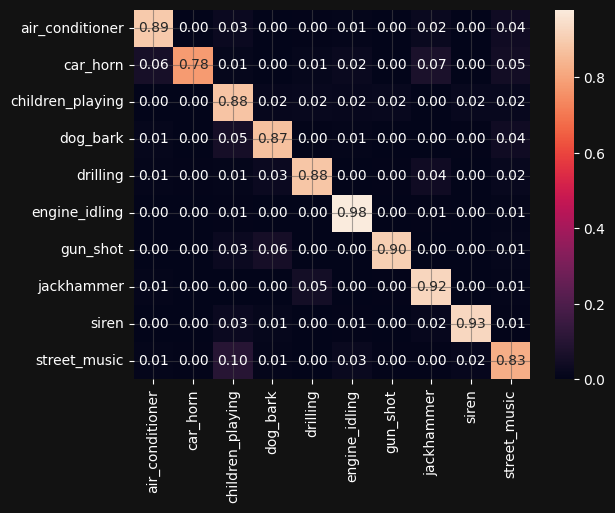

In [651]:
# Matrice de confusion normalise pour RFC
cm = confusion_matrix(y_test, y_pred_RFC, normalize='true')

sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=le.classes_, yticklabels=le.classes_)

# CNN PyTorch
---
## Objectif

L'objectif de ce TP est de construire un classifieur de sons capable d'identifier 10 catégories de bruits urbains (sirènes, aboiements, travaux, etc.). Vous allez explorer la transformation du signal audio en "images" fréquentielles et optimiser le chargement des données.

##### Tâche 4.3 : Approche Psycho-acoustique (CNN + Mel-Spectrogramme)

* Modifiez votre pipeline pour générer un **Mel-Spectrogramme** (échelle logarithmique).
* Entraînez le même CNN que précédemment.
* *Comparaison :* Observez-vous une amélioration par rapport à la STFT linéaire ?


In [652]:
def create_features_map(file_path, max_len=128):

    y, sr = librosa.load(file_path, sr=22050)
    
    # MFCC
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # padding
    def pad(x):
        if x.shape[1] < max_len:
            return np.pad(x, ((0,0),(0,max_len-x.shape[1])))
        else:
            x = x[:, :max_len]
        return x[:, :max_len]

    mel_db = pad(mel_db)

    # stack → (channels, freq, time)
    
    
    # Normalisation
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)
    # add channel dimension
    mel_db = np.expand_dims(mel_db, axis=0)  # (1, 128, 128)

    return mel_db

In [653]:
X = []
y = []

for i in range(len(df)):

    file_path = df.loc[i, "path_file"]
    features = create_features_map(file_path)
    X.append(features)
    y.append(df.loc[i, "class"])

X = np.array(X)
y = np.array(y)

c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [654]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)
X_test.shape, X_train.shape

((1747, 1, 128, 128), (6985, 1, 128, 128))

In [655]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# преобразуем в torch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [656]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

In [657]:
class ModelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.Dropout2d(0.25),   
            nn.ReLU(),              
            nn.MaxPool2d(2),      

            nn.Conv2d(16, 32, 3, padding=1),
            nn.Dropout2d(0.25), 
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), 
            nn.Dropout2d(0.25),
            nn.ReLU(),
            nn.MaxPool2d(2)       
        )

        self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Dropout2d(0.4),
                nn.Linear(16384, 10)  # logits
            )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [658]:
model_CNN = ModelCNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer_CNN = optim.AdamW(model_CNN.parameters(), lr=1e-4)


scheduler_CNN = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_CNN,
    mode="min",
    factor=0.5,
    patience=1
)

In [659]:
def train(model, criterion, optimizer, scheduler, num_epochs):

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):

        model.train()   # changer le mode de model

        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()   #  la remise à zéro des gradients à chaque itération
            outputs = model(inputs)   # la propagation avant (forward pass)
            loss = criterion(outputs, labels)   # le calcul de la perte 
            loss.backward()   # la rétro-propagation du gradient (backward pass)
            optimizer.step()   # la mise à jour des paramètres du modèle

            running_loss += loss.item() * inputs.size(0)   # calculer le loss total
            _, predicted = torch.max(outputs, 1)   # faire une predicte
            total += labels.size(0)   # quantite les prediction total
            correct += (predicted == labels).sum().item()   # quantite les prediction corect


        current_lr = optimizer.param_groups[0]['lr']    # learning rate courant
        
        train_losses.append(running_loss / total)   # souvegarger le loss
        train_accuracies.append(correct / total)   # souvegarger l'accurancy'
        
        # Evaluation sur le test set
        model.eval()   # changer le mode de model

        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        scheduler.step(running_loss)

        test_losses.append(running_loss / total)
        test_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f} | "
            f"Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_accuracies[-1]:.4f} | "
            f"Learning rate: {current_lr:.6f}")
    return train_losses, train_accuracies, test_losses, test_accuracies



In [660]:
num_epochs = 50

history_CNN = train(model_CNN, criterion, optimizer_CNN, scheduler_CNN, num_epochs)

c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/50 | Train Loss: 1.9176 | Train Acc: 0.2956 | Test Loss: 1.5672 | Test Acc: 0.4465 | Learning rate: 0.000100
Epoch 2/50 | Train Loss: 1.5722 | Train Acc: 0.4392 | Test Loss: 1.3880 | Test Acc: 0.5524 | Learning rate: 0.000100
Epoch 3/50 | Train Loss: 1.4131 | Train Acc: 0.5085 | Test Loss: 1.2506 | Test Acc: 0.5781 | Learning rate: 0.000100
Epoch 4/50 | Train Loss: 1.2730 | Train Acc: 0.5671 | Test Loss: 1.1317 | Test Acc: 0.6056 | Learning rate: 0.000100
Epoch 5/50 | Train Loss: 1.1914 | Train Acc: 0.5963 | Test Loss: 1.0614 | Test Acc: 0.6703 | Learning rate: 0.000100
Epoch 6/50 | Train Loss: 1.0951 | Train Acc: 0.6338 | Test Loss: 0.9869 | Test Acc: 0.7081 | Learning rate: 0.000100
Epoch 7/50 | Train Loss: 1.0331 | Train Acc: 0.6639 | Test Loss: 0.9579 | Test Acc: 0.7121 | Learning rate: 0.000100
Epoch 8/50 | Train Loss: 0.9814 | Train Acc: 0.6737 | Test Loss: 0.9264 | Test Acc: 0.7189 | Learning rate: 0.000100
Epoch 9/50 | Train Loss: 0.9340 | Train Acc: 0.6911 | Test Loss:

In [661]:
def show_result(train_losses, train_accuracies, test_losses, test_accuracies):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss par Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Accuracy par Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()


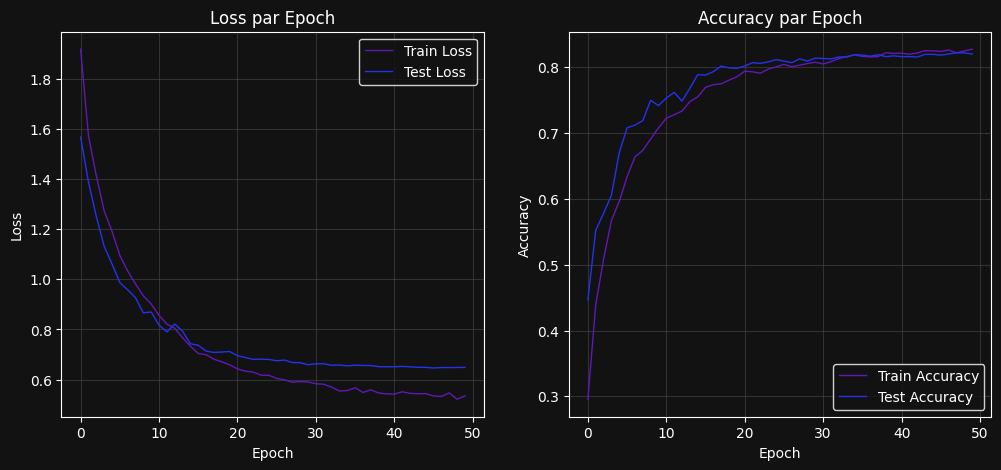

In [662]:
show_result(*history_CNN)

In [663]:
def pred_model(model):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

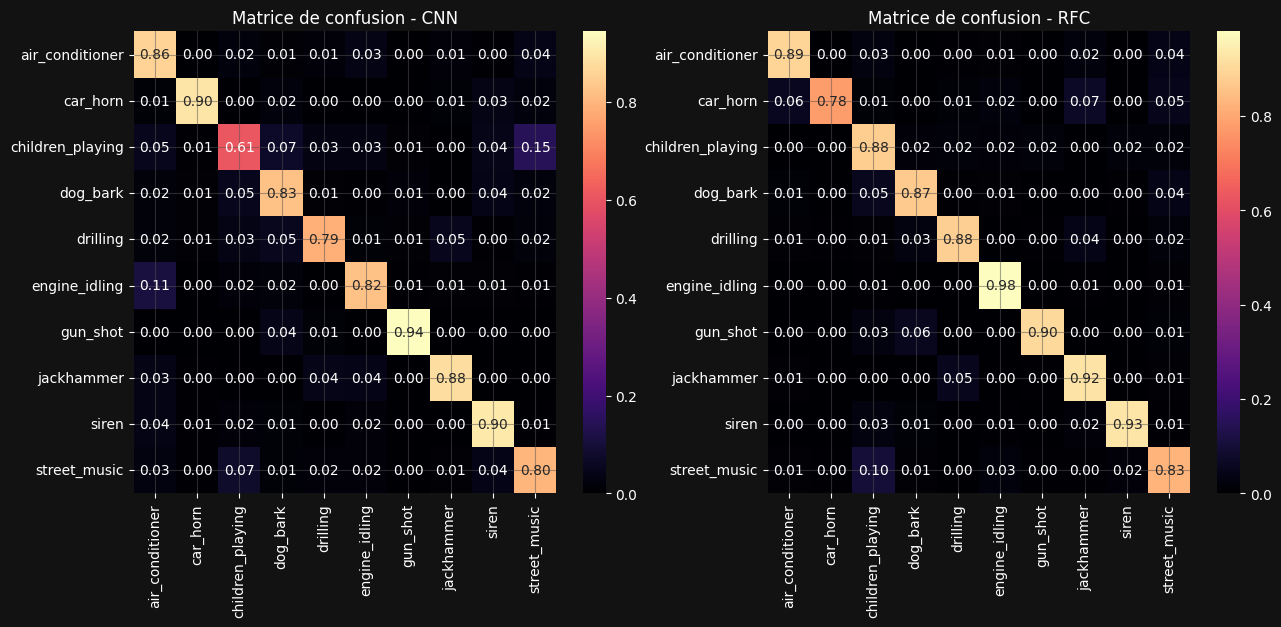

In [664]:
model_CNN.eval()

all_labels, all_preds = pred_model(model_CNN)
# Matrice de confusion
cm_CNN = confusion_matrix(all_labels, all_preds, normalize="true")


fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(cm_CNN, annot=True, fmt=".2f", cmap="magma", xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
sns.heatmap(cm, annot=True, fmt=".2f", cmap="magma", xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])

axes[0].set_title("Matrice de confusion - CNN")
axes[1].set_title("Matrice de confusion - RFC")
plt.show()

In [665]:
def create_features_map_stft(file_path, max_len=128):

    y, sr = librosa.load(file_path, sr=22050)
    
    # MFCC
    D = librosa.stft(y)
    S = np.abs(D)

    # 2. Conversion en dB (échelle logarithmique)
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    # padding
    def pad(x):
        if x.shape[1] < max_len:
            return np.pad(x, ((0,0),(0,max_len-x.shape[1])))
        else:
            x = x[:, :max_len]
        return x[:, :max_len]

    S_db = pad(S_db)

    # stack → (channels, freq, time)
    
    
    # Normalisation
    S_db = (S_db - S_db.mean()) / (S_db.std() + 1e-6)
    # add channel dimension
    S_db = np.expand_dims(S_db, axis=0)  # (1, 128, 128)

    return S_db

In [666]:
X = []
y = []

for i in range(len(df)):

    file_path = df.loc[i, "path_file"]
    features = create_features_map_stft(file_path)
    X.append(features)
    y.append(df.loc[i, "class"])

X = np.array(X)
y = np.array(y)

c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [667]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)
X_test.shape, X_train.shape

# преобразуем в torch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

In [668]:
class ModelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.Dropout2d(0.25),   
            nn.ReLU(),              
            nn.MaxPool2d(2),      

            nn.Conv2d(16, 32, 3, padding=1),
            nn.Dropout2d(0.25), 
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), 
            nn.Dropout2d(0.25),
            nn.ReLU(),
            nn.MaxPool2d(2)       
        )

        self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Dropout2d(0.4),
                nn.Linear(131072, 10)  # logits
            )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [669]:
model_CNN = ModelCNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer_CNN = optim.AdamW(model_CNN.parameters(), lr=1e-4)


scheduler_CNN = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_CNN,
    mode="min",
    factor=0.75,
    patience=1
)



In [670]:
num_epochs = 50

history_CNN_2 = train(model_CNN, criterion, optimizer_CNN, scheduler_CNN, num_epochs)

c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/50 | Train Loss: 1.8011 | Train Acc: 0.3311 | Test Loss: 1.4718 | Test Acc: 0.4596 | Learning rate: 0.000100
Epoch 2/50 | Train Loss: 1.4301 | Train Acc: 0.5002 | Test Loss: 1.2165 | Test Acc: 0.6005 | Learning rate: 0.000100
Epoch 3/50 | Train Loss: 1.2469 | Train Acc: 0.5701 | Test Loss: 1.1449 | Test Acc: 0.6045 | Learning rate: 0.000100
Epoch 4/50 | Train Loss: 1.0870 | Train Acc: 0.6296 | Test Loss: 0.9806 | Test Acc: 0.7001 | Learning rate: 0.000100
Epoch 5/50 | Train Loss: 0.9763 | Train Acc: 0.6722 | Test Loss: 0.8664 | Test Acc: 0.7418 | Learning rate: 0.000100
Epoch 6/50 | Train Loss: 0.8497 | Train Acc: 0.7200 | Test Loss: 0.8275 | Test Acc: 0.7436 | Learning rate: 0.000100
Epoch 7/50 | Train Loss: 0.7635 | Train Acc: 0.7463 | Test Loss: 0.7589 | Test Acc: 0.7733 | Learning rate: 0.000100
Epoch 8/50 | Train Loss: 0.6626 | Train Acc: 0.7870 | Test Loss: 0.7568 | Test Acc: 0.7579 | Learning rate: 0.000100
Epoch 9/50 | Train Loss: 0.5921 | Train Acc: 0.8122 | Test Loss:

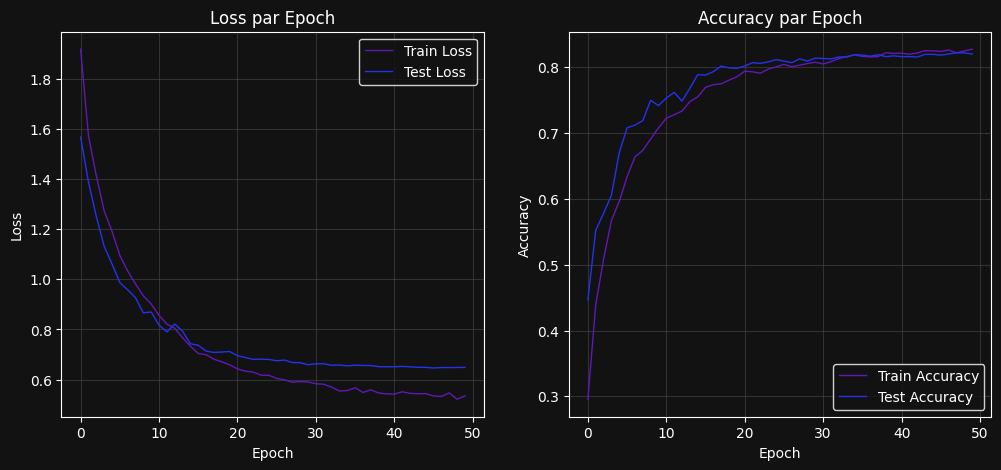

In [671]:
show_result(*history_CNN)

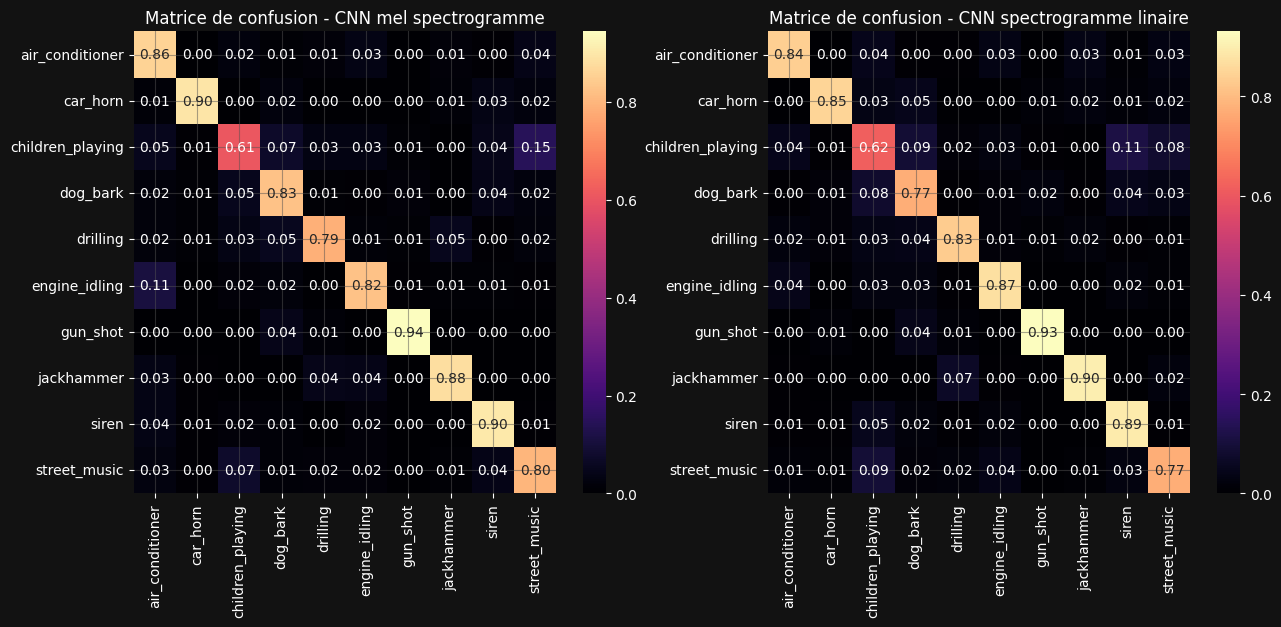

In [672]:
model_CNN.eval()

all_labels, all_preds = pred_model(model_CNN)
# Matrice de confusion
cm_CNN_2 = confusion_matrix(all_labels, all_preds, normalize="true")


fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(cm_CNN, annot=True, fmt=".2f", cmap="magma", xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
sns.heatmap(cm_CNN_2, annot=True, fmt=".2f", cmap="magma", xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])

axes[0].set_title("Matrice de confusion - CNN mel spectrogramme")
axes[1].set_title("Matrice de confusion - CNN spectrogramme linaire")
plt.show()

##### Tâche 4.4 : Le Grand Final (Architecture Multi-Input)

Construisez un modèle à deux branches utilisant l'**API Fonctionnelle** de Keras :

1. **Branche A (Image) :** Reçoit le Mel-Spectrogramme  Couches `Conv2D` + `GlobalAveragePooling`.
2. **Branche B (Vecteur) :** Reçoit les MFCC moyens  Couches `Dense`.

**Consigne :** Fusionnez les deux branches avec une couche `layers.Concatenate()` puis ajoutez les couches de décision finales (`Dense` + `Softmax`).

## TensorFlow
---
##  Analyse de Code : Le Pipeline de données

Vous allez utiliser le code suivant pour préparer vos données. **Analysez attentivement les fonctions fournies et répondez aux questions.**

**Questions de compréhension :**

1. Pourquoi utilise-t-on `tf.py_function` au lieu d'appeler directement Librosa ? Quel est l'inconvénient majeur ?
2. À quoi sert la ligne `audio.set_shape([SR])` ? Que se passe-t-il si on l'enlève ?
3. Expliquez l'intérêt de `AUTOTUNE` dans `num_parallel_calls` et `prefetch`. Quel composant matériel (CPU ou GPU) travaille à quel moment ?

In [673]:
SR = 16000

def load_audio_librosa(file_path):
    # Librosa décode presque TOUT, même les formats WAV non-standards
    audio, _ = librosa.load(file_path.numpy().decode('utf-8'), sr=SR, mono=True)
    
    # On limite/pad à 1 seconde exactement (16000 samples)
    audio = audio[:SR]
    if len(audio) < SR:
        audio = np.pad(audio, (0, SR - len(audio)))
    return audio.astype(np.float32)

def preprocess_audio(file_path, label):
    # Appel de la fonction Python via TensorFlow
    audio = tf.py_function(load_audio_librosa, [file_path], tf.float32)
    audio.set_shape([SR]) 

    # Transformation en Spectrogramme (TF natif)
    stft = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(stft)
    
    # Formatage final pour le CNN
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram = tf.image.resize(spectrogram, [128, 128])
    
    return spectrogram, label

def create_dataset(files, labels, batch_size=32,  training=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(preprocess_audio, num_parallel_calls=tf.data.AUTOTUNE)
    
    if training:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [674]:
df["fold"] = df["fold"].astype(int)

train_df = df[df["fold"] != 10]
test_df  = df[df["fold"] == 10]


y_train_int = train_df['classID']  
y_test_int  = test_df['classID']


train_ds = create_dataset(tf.constant(train_df['path_file']),
                          tf.constant(y_train_int))

test_ds = create_dataset(tf.constant(test_df['path_file']),
                          tf.constant(y_test_int))

In [675]:
for X, y in train_ds.take(1):
    print(X.shape)  # 
    print(y.shape)  # 

(32, 128, 128, 1)
(32,)


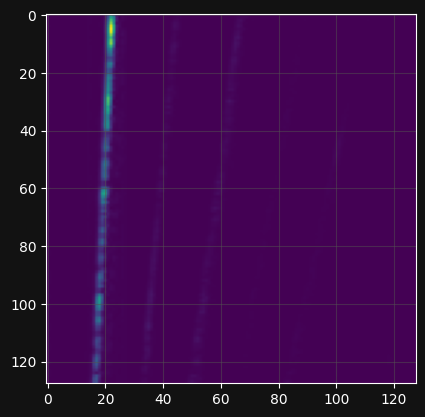

In [676]:
plt.imshow(X[8])

###  Approche Spectrale Classique (CNN + STFT)

* Utilisez le spectrogramme (STFT linéaire) généré par le pipeline `preprocess_audio`.
* Construisez un CNN 2D pour apprendre les motifs fréquentiels.



In [677]:
model_CNN_STFT = models.Sequential([
    layers.Input(shape=(128, 128, 1)),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(10, activation='softmax')
])

In [678]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4,  # начальный LR
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # за чем следим
    factor=0.5,            # во сколько раз уменьшаем LR
    patience=2,            # сколько эпох ждать без улучшения
    min_lr=1e-6,           # минимальный LR
    verbose=1
)

model_CNN_STFT.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [679]:
history_CNN_STFT = model_CNN_STFT.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
)

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 44s 162ms/step - accuracy: 0.4114 - loss: 1.7573 - val_accuracy: 0.4636 - val_loss: 1.5870
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.5058 - loss: 1.4430 - val_accuracy: 0.5376 - val_loss: 1.4227
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.5644 - loss: 1.2824 - val_accuracy: 0.5436 - val_loss: 1.3768
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 43s 165ms/step - accuracy: 0.6191 - loss: 1.1524 - val_accuracy: 0.5926 - val_loss: 1.2680
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.6437 - loss: 1.0538 - val_accuracy: 0.6177 - val_loss: 1.2324
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.6745 - loss: 0.9724 - val_accuracy: 0.6189 - val_loss: 1.1801
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.6978 - loss: 0.9067 - val_accuracy: 0.6428 - val_loss: 1.1769
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.7182 - loss: 0

In [680]:
print(history_CNN_STFT.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [694]:
test_losses = history_CNN_STFT.history["val_loss"]
test_accuracies = history_CNN_STFT.history["val_accuracy"]
train_losses = history_CNN_STFT.history["loss"]
train_accuracies = history_CNN_STFT.history["accuracy"]

In [697]:
def show_result(test_losses, test_accuracies):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(test_losses, label='Test Loss')
    plt.plot(train_losses, label='Train Loss')
    plt.title('Loss par Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.plot(train_accuracies, label='Test Accuracy')
    plt.title('Accuracy par Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()


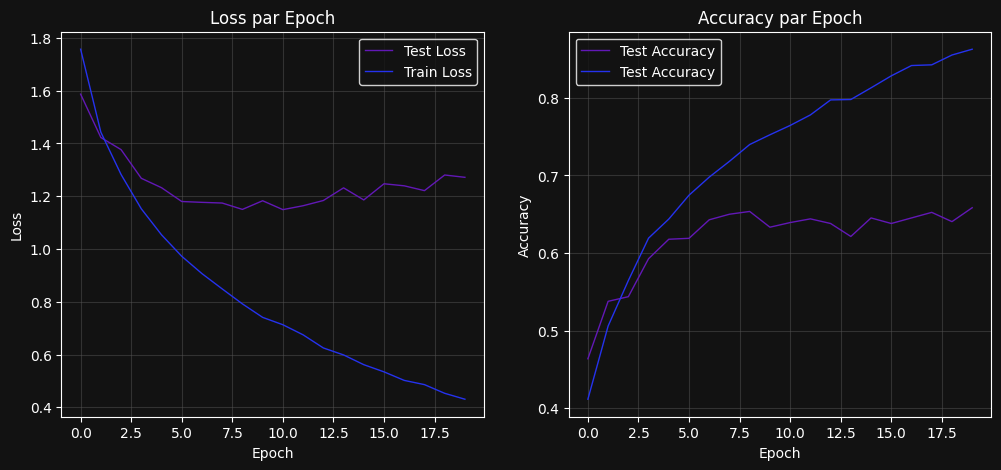

In [698]:
show_result(test_losses, test_accuracies)

In [684]:
history_CNN_STFT_2 = model_CNN_STFT.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[lr_scheduler]
)

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.8719 - loss: 0.4053 - val_accuracy: 0.6547 - val_loss: 1.2779 - learning_rate: 1.0000e-04
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.8773 - loss: 0.3854 - val_accuracy: 0.6464 - val_loss: 1.3204 - learning_rate: 1.0000e-04
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8888 - loss: 0.3517
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.8804 - loss: 0.3690 - val_accuracy: 0.6296 - val_loss: 1.3975 - learning_rate: 1.0000e-04
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 42s 162ms/step - accuracy: 0.8930 - loss: 0.3402 - val_accuracy: 0.6428 - val_loss: 1.3833 - learning_rate: 5.0000e-05
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8992 - loss: 0.3182
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - a

In [685]:
test_loss, test_accuracy = model_CNN_STFT.evaluate(test_ds)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6595 - loss: 1.4158
Test loss: 1.415847659111023
Test accuracy: 0.6594982147216797


## 4. Modélisation : De la régression simple au Multi-Input

> **Note importante :** Pour gagner du temps lors des tests, nous travaillerons uniquement sur les données du **Fold 1**.

##### Tâche 4.1 : Approche Statistique (Dense + MFCC)

Ici, on ne traite pas le son comme une image, mais comme un vecteur de caractéristiques moyennes.

* Calculez la **moyenne** des coefficients MFCC sur le temps pour chaque échantillon (on obtient un vecteur de taille 13 ou 20).
* Créez un modèle simple avec des couches `Dense` pour classifier ces vecteurs.
* *Question :* Cette approche permet-elle de capturer l'évolution temporelle du son ?


In [686]:
def load_audio_mfcc(file_path):
    audio, _ = librosa.load(file_path.numpy().decode('utf-8'),
                            sr=SR,
                            mono=True)

    audio = audio[:SR]
    if len(audio) < SR:
        audio = np.pad(audio, (0, SR - len(audio)))

    mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20)

    # статистика
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    features = np.concatenate([mfcc_mean, mfcc_std])
    features = (features - features.mean()) / (features.std() + 1e-6)

    return features.astype(np.float32)

def preprocess_audio_stat(file_path, label):
    features = tf.py_function(load_audio_mfcc,
                              [file_path],
                              tf.float32)

    features.set_shape([40])  # 20 mean + 20 std

    return features, label


In [687]:
def create_dataset_stat(files, labels, batch_size=32, repeat=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(preprocess_audio_stat, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(500)  # обязательно перемешиваем
    if repeat:
        ds = ds.repeat()  # чтобы модель видела данные каждый эпох
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [688]:
train_ds_stat = create_dataset_stat(train_df['path_file'], y_train_int)

test_ds_stat = create_dataset_stat(test_df['path_file'], y_test_int)
y_train_int = train_df['classID'].astype(np.int32)
y_test_int = test_df['classID'].astype(np.int32)


In [689]:
for x, y in train_ds_stat.take(1):
    print(x.shape, x.dtype)  # (batch_size, 40), float32
    print(y.shape, y.dtype)  # (batch_size,), int32

(32, 40) <dtype: 'float32'>
(32,) <dtype: 'int64'>


In [690]:
model_stat = models.Sequential([
    layers.Input(shape=(40,)),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [691]:
model_stat.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [692]:
print(train_df['classID'].min(), train_df['classID'].max())
print(train_df['classID'].unique())
print(train_df['classID'].dtype)

0 9
[3 2 0 9 6 8 5 7 4 1]
int64


In [693]:
steps_per_epoch = len(train_df) // 32
validation_steps = len(test_df) // 32

history_stat = model_stat.fit(
    train_ds_stat,
    validation_data=test_ds_stat,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 77s 294ms/step - accuracy: 0.2322 - loss: 2.1391 - val_accuracy: 0.3065 - val_loss: 2.0025
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 72s 293ms/step - accuracy: 0.3491 - loss: 1.8758 - val_accuracy: 0.4147 - val_loss: 1.7883
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 72s 293ms/step - accuracy: 0.4167 - loss: 1.6904 - val_accuracy: 0.4327 - val_loss: 1.6802
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 73s 297ms/step - accuracy: 0.4609 - loss: 1.5666 - val_accuracy: 0.4579 - val_loss: 1.6000
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 76s 309ms/step - accuracy: 0.4905 - loss: 1.4779 - val_accuracy: 0.4928 - val_loss: 1.5419
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 74s 302ms/step - accuracy: 0.5076 - loss: 1.4161 - val_accuracy: 0.4928 - val_loss: 1.5119
Epoch 7/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 71s 291ms/step - accuracy: 0.5269 - loss: 1.3579 - val_accuracy: 0.5349 - val_loss: 1.4857
Epoch 8/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 71s 292ms/step - accuracy: 0.5404 - loss: 1

In [699]:
test_losses = history_stat.history["val_loss"]
test_accuracies = history_stat.history["val_accuracy"]
train_losses = history_stat.history["loss"]
train_accuracies = history_stat.history["accuracy"]

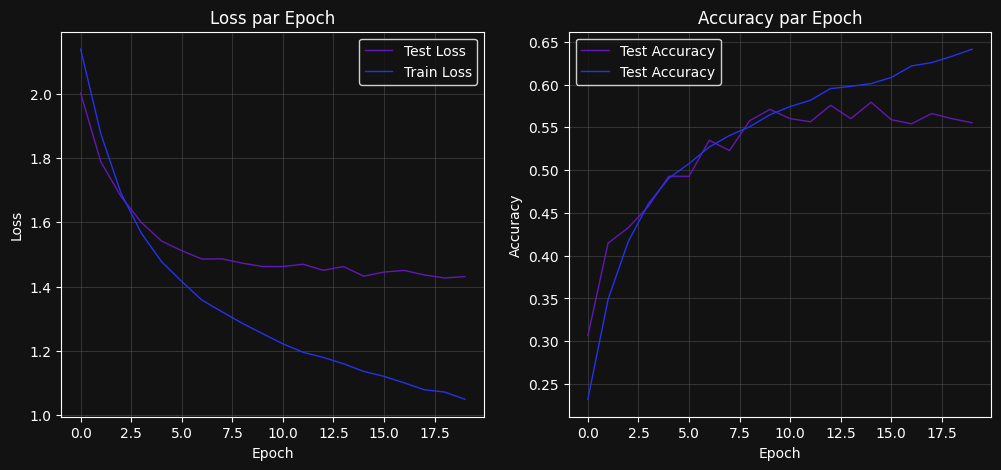

In [700]:
show_result(test_losses, test_accuracies)

## 5. Évaluation des performances

L'accuracy ne suffit pas pour UrbanSound8K.

* **Tâche 5.1 :** Affichez la **Matrice de Confusion**. Quelles classes l'IA confond-elle le plus ? Pourquoi (selon votre analyse des sons) ?
* **Tâche 5.2 :** Générez un **Rapport de Classification** (Précision, Rappel, F1-score).
* **Tâche 5.3 :** Testez votre modèle sur un son téléchargé sur Internet (format MP3 ou WAV). Votre IA est-elle robuste au monde réel ?